In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np
pd.set_option('display.max_columns', 200)
import warnings
warnings.filterwarnings('ignore')
import re
import csv
import os
from matplotlib_venn import venn2
import re
import itertools
from collections import Counter
from fpdf import FPDF

### Entradas

* LOI.csv
* results.csv (resultado do SDG)
* revList.csv (do SDG)
* soot-results.csv (resultado do Static Analysis)

In [2]:
def extract_method_name(signature):
    method_full_name = signature.split('(')[0]
    method_name = method_full_name.split('.')[-1]
    return method_name

In [3]:
# Name of the CSV file
file_name = 'revList.csv'

# List to store the DataFrames
found_files = []

# Open the CSV file for reading
with open(file_name, mode='r', newline='', encoding='utf-8') as file:
    # Create a CSV reader
    csv_reader = csv.reader(file, delimiter=';')
    
    # Skip the first line (header)
    next(csv_reader)
    cont = 0
    # Read the remaining lines and process each line
    for row in csv_reader:
        project = row[0]
        merge_commit = row[1]
        class_name = row[2]
        method = row[3]
        # left_modification = row[4]
        # has_build = row[5]
        # left_deletion = row[6]
        # right_modification = row[7]
        # right_deletion = row[8]
        # realistic_case_path = row[9]

        # Generate path
        parts = class_name.split('.')
        class_name = parts.pop()
        class_path = '.'.join(parts).replace(".", "/")
        method_name = extract_method_name(method)
        
        path_file = f"joana/reports/{project}/{merge_commit}/{class_path}/{class_name}/{method_name}/executionSummary.csv"
        
        if os.path.exists(path_file):
            try:
                df = pd.read_csv(path_file, sep=';')
                # Add context columns to the DataFrame
                df['project'] = project
                df['merge commit'] = merge_commit
                df['class'] = class_name
                df['original method'] = method

            except:
                print(f"Error: The file '{path_file}' is empty.")
                data = {
                'project': project,
                'merge commit': merge_commit,
                'class': class_name,
                'original method': [method]
                }
                
                df = pd.DataFrame(data)

        else:
            print(path_file)
            cont+=1
            data = {
                'project': project,
                'merge commit': merge_commit,
                'class': class_name,
                'original method': [method]
            }
            
            df = pd.DataFrame(data)
        print(df.columns)
        # Reorder columns to have new columns at the beginning
        columns_order = ['project', 'merge commit', 'class', 'original method'] + [col for col in df.columns if col not in ['project', 'merge commit', 'class', 'original method']]
        df = df[columns_order]
        found_files.append(df)

    print("Não existem", cont)
    # Check if there are DataFrames to concatenate
    if len(found_files) > 0:
        # Concatenate all DataFrames, keeping all rows and columns
        merged_file = pd.concat(found_files, ignore_index=True, sort=False)

        merged_file = merged_file.drop(columns=['Method'])

        # Save the result to a new CSV file with ';' as separator
        merged_file.to_csv('merged_file.csv', index=False, sep=';')
        print("Files merged successfully! File saved as 'merged_file.csv'.")
    else:
        print("No file was found!")


Index(['Method', ' Precision', ' Exceptions', ' SdgCreated', ' CgNodes',
       ' CgEdges', ' SdgNodes', ' SdgEdges', ' Time (ms)', ' Memory (M)',
       ' HasSourcedAndSink', ' HasLeftToRightVio', ' HasRightToLeftVio',
       ' TotalVios', ' InstVios', ' LineVios', ' DetailedLineVios', ' Left',
       ' Right', 'project', 'merge commit', 'class', 'original method'],
      dtype='object')
Index(['Method', ' Precision', ' Exceptions', ' SdgCreated', ' CgNodes',
       ' CgEdges', ' SdgNodes', ' SdgEdges', ' Time (ms)', ' Memory (M)',
       ' HasSourcedAndSink', ' HasLeftToRightVio', ' HasRightToLeftVio',
       ' TotalVios', ' InstVios', ' LineVios', ' DetailedLineVios', ' Left',
       ' Right', 'project', 'merge commit', 'class', 'original method'],
      dtype='object')
Index(['Method', ' Precision', ' Exceptions', ' SdgCreated', ' CgNodes',
       ' CgEdges', ' SdgNodes', ' SdgEdges', ' Time (ms)', ' Memory (M)',
       ' HasSourcedAndSink', ' HasLeftToRightVio', ' HasRightToLeftVi

Reading analyses execution results...
Generating results...
No No
DataSegment com.metamx.druid.loading.S3SegmentPusher.push(File, DataSegment)
No No
Object org.jboss.netty.handler.codec.frame.LengthFieldBasedFrameDecoder.decode(ChannelHandlerContext, Channel, ChannelBuffer)
 No  Yes
boolean org.opentripplanner.routing.spt.MultiShortestPathTree.dominates(State, State)
No No
 void org.webbitserver.netty.WebSocketClient$HandshakeChannelHandler.adjustPipelineToWebSocket(ChannelHandlerContext, MessageEvent, ChannelHandler, ChannelHandler)
No No
String org.fusesource.restygwt.rebind.DirectRestServiceInterfaceClassCreator.getMethodCallback(JMethod)
nan nan
void org.apache.storm.kafka.spout.KafkaSpout.open(Map, TopologyContext, SpoutOutputCollector)
No No
void org.apache.storm.kafka.spout.KafkaSpoutConfig.KafkaSpoutConfig(Builder<K,V>)
No No
 String org.apache.storm.kafka.spout.KafkaSpoutConfig.toString()
 Yes  No
boolean org.apache.storm.kafka.spout.KafkaSpout.emitTupleIfNotEmitted(ConsumerRe

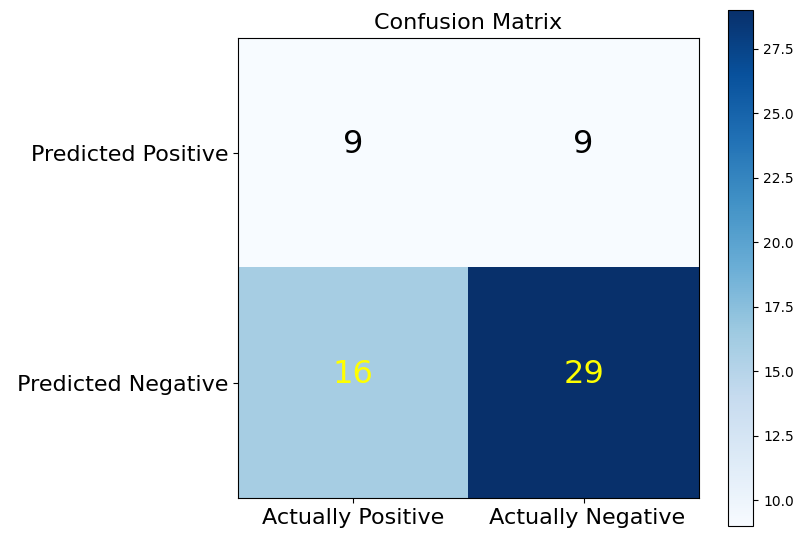

In [4]:
class ReportAnalysis:

    def __init__(self, path_result, path_ground_truth):
        self.soot_results = pd.read_csv(path_result, sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)
        self.loi = pd.read_csv(path_ground_truth, sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)

        self.generate_results()

    def get_method_name(self, method_declaration):
        match = re.search(r'\.([a-zA-Z_][a-zA-Z0-9_]*)\(', method_declaration)
        if match:
            method_name = match.group(1)
            print("Method name:", method_name)
        else:
            print("Method name not found.")

    def get_loi(self, project, class_name, method, merge_commit):
        df = pd.read_csv("LOI.csv", delimiter=';')
        print(method)
        # Encontrar o índice do ponto final e do parêntese
        dot_index = method.rfind('.')
        paren_index = method.find('(')

        method_name = ""

        # Extrair o nome do método
        if dot_index != -1 and paren_index != -1:
            method_name = method[dot_index + 1:paren_index]

        value_LOI = ("", "")
        
        for project_l, class_name_l, method_l, merge_commit_l, LOI, original_sample in zip(
            df['Project'], 
            df['Class Name'], 
            df['Method or field declaration changed by the two merged branches'], 
            df['Merge Commit'], 
            df['Locally Observable Interference'],
            df['Original Sample'],
        ):
            if (project_l == project and 
                class_name in class_name_l  and 
                method_name in method_l and 
                merge_commit_l == merge_commit):
                
                value_LOI = (LOI, original_sample)

                break  # Para parar no primeiro match encontrado

        return value_LOI

    def calculate_matrix_loi(self, columns):
        results = []
        loi_list = []
        original_sample_list = []
        info_LOI = ['project', 'class', 'original method', 'merge commit']
        
        # Limpar espaços em branco nos nomes das colunas
        self.soot_results.columns = self.soot_results.columns.str.strip()
        #print("Colunas:", self.soot_results.columns)
        for index, row in self.soot_results.iterrows():
            value1 = "No" if "-" in str(row['HasLeftToRightVio']) else row['HasLeftToRightVio']
            value2 = "No" if "-" in str(row['HasRightToLeftVio']) else row['HasRightToLeftVio']
            sdg_created = row['SdgCreated']
            
            print(value1, value2)
            values_LOI = [row[column] for column in info_LOI if column in row]
            #print("Colunas: ", values_LOI)
            (loi_actual, original_sample) = self.get_loi(*values_LOI)
            
            loi_list.append(loi_actual)
            original_sample_list.append(original_sample)

            result = "-"
            # Determinar o resultado
            if "Yes" in str(sdg_created):
                if ( "Yes" in str(value1) or "Yes" in str(value2) ) and "Yes" in loi_actual:
                    result = "TRUE POSITIVE"
                elif ( "No" in str(value1) and "No" in str(value2) ) and "No" in loi_actual:
                    result = "TRUE NEGATIVE"
                elif ( "No" in str(value1) and "No" in str(value2) ) and "Yes" in loi_actual:
                    result = "FALSE NEGATIVE"
                elif ("Yes" in str(value1) or "Yes" in str(value2) ) and "No" in loi_actual:
                    result = "FALSE POSITIVE"
            
            results.append(result)
            
        df = pd.read_csv('merged_file.csv', sep=';')
        df['LOI'] = loi_list
        df['Original Sample'] = original_sample_list
        df['result'] = results

        # Salvar o novo DataFrame em um novo arquivo CSV
        new_csv_path = 'output/results.csv'
        df.to_csv(new_csv_path, sep=';', index=False)

        return results

    def generate_results(self):

        print("Generating results...")

        FP,TP, FN, TN = 0, 0, 0, 0

        list_columns = self.soot_results.columns.tolist()

        result_matrix = self.calculate_matrix_loi(list_columns)

        for elem, count in Counter(result_matrix).items():
            if (elem == 'FALSE POSITIVE'):
                FP = count
            if (elem == 'FALSE NEGATIVE'):
                FN = count
            if (elem == 'TRUE POSITIVE'):
                TP = count
            if (elem == 'TRUE NEGATIVE'):
                TN = count

        sensitivity = 0 if ((TP + FN) == 0) else (TP / (TP + FN))
        precision = 0 if ((TP + FP) == 0) else (TP / (TP + FP))
        f1_score = 0 if ((2*TP + FP + FN) == 0) else (2*TP / (2*TP + FP + FN))
        accuracy = 0 if ((FP + TP + TN + FN) == 0) else ((TP + TN) / (FP + TP + TN + FN))

        df = pd.read_csv("output/results.csv", sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)
       
        fail_results = df['result'].eq("-").sum()
        total = len(df)

        # variable pdf
        pdf = FPDF()

        # add a page
        pdf.add_page()

        # set style and size of font
        # that you want in the pdf
        pdf.set_font("Arial", size = 15)

        # create a cell
        pdf.cell(200, 10, txt = "Results for execution",
                 ln = 1, align = 'C')
    
        pdf.cell(200, 10, txt = ("Precision: "+str(round(precision, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("Recall: "+str(round(sensitivity, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("F1 Score: "+str(round(f1_score, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("Accuracy: "+str(round(accuracy, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("False Positives: "+str(FP)),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("False Negatives: "+str(FN)),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("True Positives: "+str(TP)),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("True Negatives: "+str(TN)),
                 ln = 2, align = 'L')
        
        pdf.cell(200, 10, txt = (f"Total produzed: {total-fail_results} out of {total} units"),
                 ln = 2, align = 'L')

        cm = np.array([[TP,  FP], [FN, TN]])
        normalize = False
        target_names = ['Actually Positive', ' Actually Negative']
        target_names2 = ['Predicted Positive', ' Predicted Negative']
        title = "Confusion Matrix"

        cmap = plt.get_cmap('Blues')

        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title, fontsize=16)
        plt.colorbar()

        if target_names is not None:
            tick_marks = np.arange(len(target_names))
            plt.xticks(tick_marks, target_names, fontsize=16)
            plt.yticks(tick_marks, target_names2, fontsize=16)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        thresh = cm.max() / 1.5 if normalize else cm.max() / 2
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="yellow" if cm[i, j] > thresh else "black", fontsize=23)
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="yellow" if cm[i, j] > thresh else "black", fontsize=23)
        plt.tight_layout()

        plt.savefig("output/confusion_matrix.jpg")

        pdf.image("output/confusion_matrix.jpg", x = None, y = None, w = 160, h = 110, type = 'jpg', link = 'output/confusion_matrix.jpg')

        # Save the pdf with name .pdf
        pdf.output("output/results.pdf")
        # pdf.output("output/results.pdf")

        print("Results in output/results.pdf")

path_ground_truth = "LOI.csv"
path_result = 'merged_file.csv'

print("Reading analyses execution results...")

ReportAnalysis(path_result, path_ground_truth)

#project, class_name, method, merge_commit
#Colunas:  ['druid', 'S3SegmentPusher', '05168808c278c080c59c19e858d9471b316cd1f5']



In [5]:

path_result = 'merged_file.csv'

print("Reading analyses execution results...")
soot_results = pd.read_csv(path_result, sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)

soot_results.columns = soot_results.columns.str.strip()
list_time_seconds = []

for index, row in soot_results.iterrows():
    value = row['Time (ms)']
    try:
        # Ignora valores que não são numéricos, como ' -'
        if str(value) not in ['', '-', 'NaN', 'nan']:
            list_time_seconds.append(float(value) / 1000)
    except ValueError:
        continue
       
print(list_time_seconds)


Reading analyses execution results...
[315588.464, 21348.974, 100.579, 65082.656, 26803.017, 1211.92, 696.403, 89.049, 697.192, 90.523, 477.295, 477.295, 86.424, 12111.004, 16307.385, 164.854, 100.277, 3263.51, 107.059, 96.957, 38084.959, 822.349, 2230.173, 385.715, 91.636, 602.84, 88.886, 195922.58, 20662.537, 373.994, 17702.926, 62096.918, 110039.556, 94.52, 102.778, 102.778, 3213.311, 3425.11, 2935.97, 3404.508, 91.999, 88.851, 85.73, 115.644, 90562.435, 104.78, 104.78, 104.78, 5810.294, 7253.081, 5558.994, 84.81, 54853.537, 1338.891, 91.161, 1991.138, 96.273, 84.869, 374.23, 2239.917, 2233.36, 613.914, 239.341]


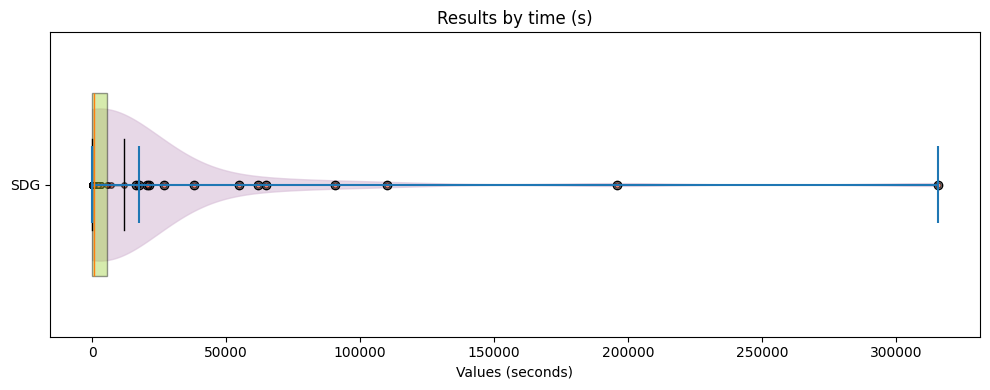

In [6]:
import random

# Exemplo de classe que utiliza a função plot_by_variable
class Plotter:
    def __init__(self):
        pass

    def plot_by_variable(self, leg1, leg_x, time_list1):
        # Define o tamanho da figura
        fig, ax = plt.subplots(figsize=(10, 4))

        # Dados
        data_x = [time_list1]

        # Cores para os gráficos
        boxplot_color = 'yellowgreen'
        violin_color = 'thistle'
        scatter_color = 'tomato'

        # Boxplot
        bp = ax.boxplot(data_x, patch_artist=True, vert=False, positions=[1], widths=0.6)
        for patch in bp['boxes']:
            patch.set_facecolor(boxplot_color)
            patch.set_alpha(0.4)

        # Violinplot
        vp = ax.violinplot(data_x, points=500, showmeans=True, showextrema=True, showmedians=False, vert=False)
        for b in vp['bodies']:
            b.set_color(violin_color)
            b.set_alpha(0.6)

        # Scatterplot
        features = data_x[0]
        y = np.full(len(features), 1)  # Usando apenas 1 para a posição no eixo Y
        jitter = np.random.uniform(low=-0.1, high=0.1, size=len(features))
        ax.scatter(features + jitter, y, s=15, c=scatter_color, alpha=0.7, edgecolor='k')

        # Configurações do gráfico
        ax.set_yticks([1])
        ax.grid(False)
        ax.set_yticklabels([leg1])
        ax.set_xlabel(leg_x)
        ax.set_title("Results by time (s)")
        plt.tight_layout()
        plt.savefig("output/rain_cloud_time_sdg.jpg", dpi=300)
        plt.show()

    
# Criar uma instância da classe ExamplePlotter
plotter = Plotter()

# Nome da variável a ser plotada
y = "SDG"
x = "Values (seconds)"

# Chamar a função para plotar o gráfico
plotter.plot_by_variable(y, x, list_time_seconds)

#time_list = [random.uniform(0.5, 3.5) for _ in range(100)]
#plotter.plot_by_variable(y, x, time_list)


In [7]:
import statistics

def converter_segundos(tempo_em_segundos):
    horas = int(tempo_em_segundos // 3600)
    minutos = int((tempo_em_segundos % 3600) // 60)
    segundos = tempo_em_segundos % 60
    return horas, minutos, segundos

tempo_em_segundos = max(list_time_seconds)
horas, minutos, segundos = converter_segundos(tempo_em_segundos)

print(f"{horas} horas, {minutos} minutos e {segundos:.3f} segundos")

87 horas, 39 minutos e 48.464 segundos


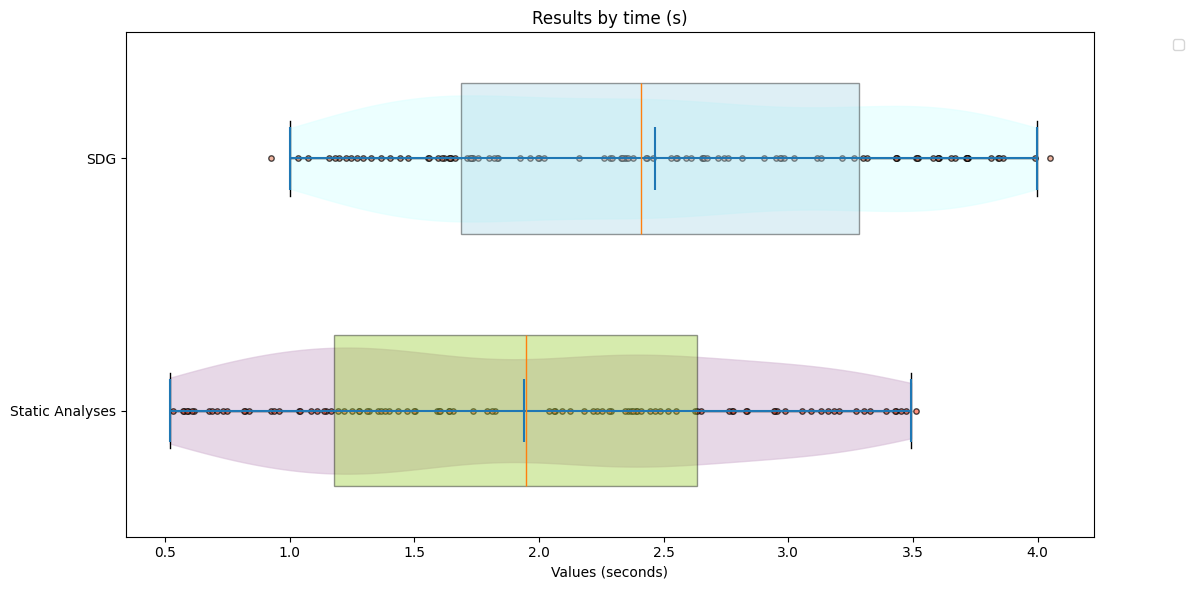

In [8]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Exemplo de classe que utiliza a função plot_by_variable
class Plotter:
    def __init__(self):
        pass

    def plot_by_variable(self, leg1, leg2, leg_x, time_list1, time_list2):
        # Define o tamanho da figura
        fig, ax = plt.subplots(figsize=(12, 6))

        # Dados
        data_x = [time_list1, time_list2]

        # Cores para os gráficos
        boxplots_colors = ['yellowgreen', 'lightblue']
        violin_colors = ['thistle', 'lightcyan']
        scatter_colors = ['tomato', 'darksalmon']

        # Boxplot
        bp = ax.boxplot(data_x, patch_artist=True, vert=False, positions=[1, 2], widths=0.6)
        for patch, color in zip(bp['boxes'], boxplots_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.4)

        # Violinplot
        vp = ax.violinplot(data_x, points=500, showmeans=True, showextrema=True, showmedians=False, vert=False)
        for idx, b in enumerate(vp['bodies']):
            b.set_color(violin_colors[idx])
            b.set_alpha(0.6)

        # Scatterplot
        for idx, features in enumerate(data_x):
            y = np.full(len(features), idx + 1)
            jitter = np.random.uniform(low=-0.1, high=0.1, size=len(features))
            ax.scatter(features + jitter, y, s=15, c=scatter_colors[idx], alpha=0.7, edgecolor='k')

        # Configurações do gráfico
        ax.set_yticks([1, 2])
        ax.grid(False)
        ax.set_yticklabels([leg1, leg2])
        ax.set_xlabel(leg_x)
        ax.set_title("Results by time (s)")
        ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
        plt.tight_layout()
        plt.savefig("output/rain_cloud_time_sdg_sam.jpg", dpi=300)
        plt.show()

       
# Criar uma instância da classe Plotter
plotter = Plotter()

# Gerar duas listas de tempos de exemplo (em segundos)
random.seed(42)  # Para reprodutibilidade
time_list1 = [random.uniform(0.5, 3.5) for _ in range(100)]
time_list2 = [random.uniform(1.0, 4.0) for _ in range(100)]

# Nome da variável a ser plotada
variable = "Execution Time"

# Chamar a função para plotar o gráfico
plotter.plot_by_variable("Static Analyses", "SDG", "Values (seconds)", time_list1, time_list2)


Reading analyses execution results...
Reading analyses execution results...
Generating results...
Results in output/results_static.pdf


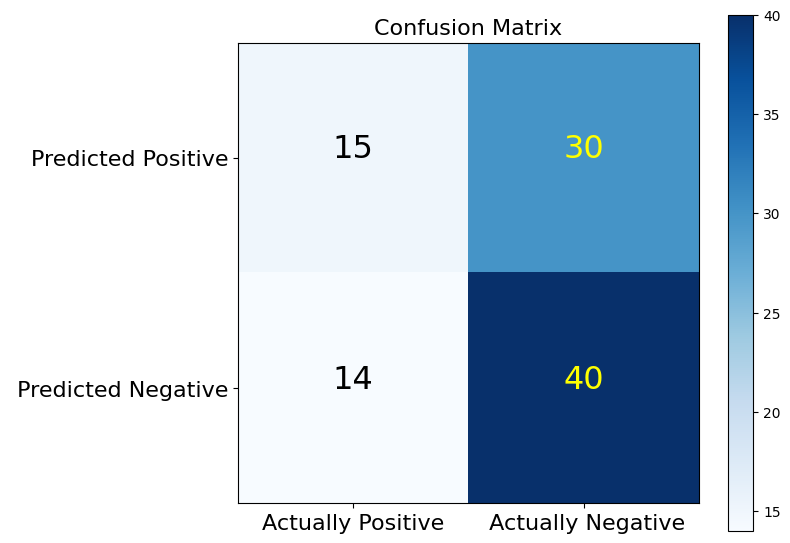

In [9]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter
from matplotlib import pyplot as plt
from fpdf import FPDF

class ReportAnalysis:

    def __init__(self, path_result, path_ground_truth):
        self.soot_results = pd.read_csv(path_result, sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)
        self.loi = pd.read_csv(path_ground_truth, sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)

        self.generate_results()

    def get_loi(self, project, class_name,  method, merge_commit):

        filter_scenario = (self.loi['Project'] == str(project)) & (self.loi['Merge Commit'] == str(merge_commit)) & (self.loi['Class Name'] == str(class_name)) & (self.loi['Method or field declaration changed by the two merged branches'] == str(method))
        value_LOI = ""

        if filter_scenario.any():
            value_LOI = self.loi.loc[filter_scenario, 'Locally Observable Interference'].values[0]

        return value_LOI

    def calculate_matrix_loi(self, columns):
        results = []
        loi_list = []
        info_LOI = ['project', 'class', 'method', 'merge commit']

        for index, row in self.soot_results.iterrows():
            list_values = self.soot_results.columns.tolist()
            remove_columns = ['project', 'class', 'method', 'merge commit', 'Time']
            list_values = [coluna for coluna in list_values if coluna not in remove_columns]
            values = [row[column] for column in list_values]

            values_LOI = [row[column] for column in info_LOI]

            loi_actual = self.get_loi(*values_LOI)
            loi_list.append(loi_actual)
            or_value = any(str(value).lower() != 'false' for value in values)

            result = ""
            if or_value == True and loi_actual == 'Yes':
                result = "TRUE POSITIVE"
            elif or_value == False and loi_actual == 'No':
                result = "TRUE NEGATIVE"
            elif or_value == False and loi_actual == 'Yes':
                result = "FALSE NEGATIVE"
            elif or_value == True and loi_actual == 'No':
                result = "FALSE POSITIVE"
            results.append(result)


        self.soot_results['LOI'] = loi_list
        self.soot_results['result'] = results

        self.soot_results.to_csv('output/result_static.csv', sep=';', index=False)

        return results
            
    def generate_results(self):

        print("Generating results...")

        FP,TP, FN, TN = 0, 0, 0, 0

        list_columns = self.soot_results.columns.tolist()

        result_matrix = self.calculate_matrix_loi(list_columns)

        for elem, count in Counter(result_matrix).items():
            if (elem == 'FALSE POSITIVE'):
                FP = count
            if (elem == 'FALSE NEGATIVE'):
                FN = count
            if (elem == 'TRUE POSITIVE'):
                TP = count
            if (elem == 'TRUE NEGATIVE'):
                TN = count

        sensitivity = 0 if ((TP + FN) == 0) else (TP / (TP + FN))
        precision = 0 if ((TP + FP) == 0) else (TP / (TP + FP))
        f1_score = 0 if ((2*TP + FP + FN) == 0) else (2*TP / (2*TP + FP + FN))
        accuracy = 0 if ((FP + TP + TN + FN) == 0) else ((TP + TN) / (FP + TP + TN + FN))

        # variable pdf
        pdf = FPDF()

        # add a page
        pdf.add_page()

        # set style and size of font
        # that you want in the pdf
        pdf.set_font("Arial", size = 15)

        # create a cell
        pdf.cell(200, 10, txt = "Results for execution",
                 ln = 1, align = 'C')

        pdf.cell(200, 10, txt = ("Precision: "+str(round(precision, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("Recall: "+str(round(sensitivity, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("F1 Score: "+str(round(f1_score, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("Accuracy: "+str(round(accuracy, 2))),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("False Positives: "+str(FP)),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("False Negatives: "+str(FN)),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("True Positives: "+str(TP)),
                 ln = 2, align = 'L')

        pdf.cell(200, 10, txt = ("True Negatives: "+str(TN)),
                 ln = 2, align = 'L')

        cm = np.array([[TP,  FP], [FN, TN]])
        normalize = False
        target_names = ['Actually Positive', ' Actually Negative']
        target_names2 = ['Predicted Positive', ' Predicted Negative']
        title = "Confusion Matrix"

        cmap = plt.get_cmap('Blues')

        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title, fontsize=16)
        plt.colorbar()

        if target_names is not None:
            tick_marks = np.arange(len(target_names))
            plt.xticks(tick_marks, target_names, fontsize=16)
            plt.yticks(tick_marks, target_names2, fontsize=16)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        thresh = cm.max() / 1.5 if normalize else cm.max() / 2
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="yellow" if cm[i, j] > thresh else "black", fontsize=23)
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="yellow" if cm[i, j] > thresh else "black", fontsize=23)
        plt.tight_layout()

        plt.savefig("output/confusion_matrix.jpg")

        pdf.image("output/confusion_matrix.jpg", x = None, y = None, w = 160, h = 110, type = 'jpg', link = 'output/confusion_matrix.jpg')

        # Save the pdf with name .pdf
        pdf.output("output/results_static.pdf")
    
        print("Results in output/results_static.pdf")


print("Reading analyses execution results...")

path_ground_truth = "LOI.csv"
path_result = 'soot-results.csv'
list_calculate = ['Confluence Inter', 'OA Inter', 'left right DFP-Inter', 'right left DFP-Inter', 'left right PDG', 'right left PDG']
print("Reading analyses execution results...")

ReportAnalysis(path_result, path_ground_truth)



In [10]:
#aqui é assumindo que não teve problema na execução

df1 = pd.read_csv("output/results.csv", sep=";")

df1["method"] = df1["original method"].apply(
    lambda x: re.search(r"\.([a-zA-Z0-9_]+)\(", x.strip()).group(1) 
    if isinstance(x, str) and re.search(r"\.([a-zA-Z0-9_]+)\(", x.strip()) else ""
)

method_column = df1.pop("method")  # Remover a coluna 'method'
df1.insert(df1.columns.get_loc("original method"), "method", method_column)  # Inserir na posição correta

df1 = df1.drop(columns=["original method"])

df1.to_csv("output/df_sdg.csv", sep=";", index=False)

In [11]:
df1 = pd.read_csv("output/result_static.csv", sep=";")

df1["method"] = df1["method"].apply(
    lambda x: re.match(r"([a-zA-Z0-9_]+)", x).group(1) if isinstance(x, str) else ""
)

df1["class"] = df1["class"].apply(
    lambda x: x.split('.')[-1] if isinstance(x, str) else ""
)

df1.to_csv("output/df_static.csv", sep=";", index=False)


Relatório e diagrama de Venn salvos com sucesso em 'relatorio_completo.pdf'.


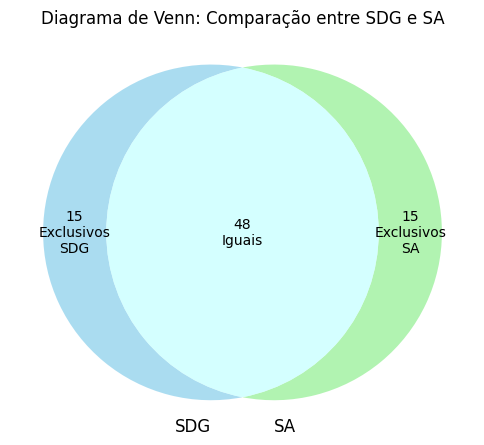

In [12]:
def get_result_from_df(df, project, merge_commit, class_name, method_name):
    matching_row = df[
        (df["project"].str.contains(project, na=False)) &
        (df["merge commit"].str.contains(merge_commit, na=False)) &
        (df["class"].str.contains(class_name, na=False)) &
        (df["method"].str.contains(method_name, na=False))
    ]
    
    return matching_row["result"].iloc[0] if not matching_row.empty else None

df1 = pd.read_csv("output/df_sdg.csv", sep=";")
df2 = pd.read_csv("output/df_static.csv", sep=";")

resultados = []

sdg_exclusivos = {"TRUE POSITIVE": 0, "FALSE POSITIVE": 0, "TRUE NEGATIVE": 0, "FALSE NEGATIVE": 0}
sa_exclusivos = {"TRUE POSITIVE": 0, "FALSE POSITIVE": 0, "TRUE NEGATIVE": 0, "FALSE NEGATIVE": 0}

sdg_counts = {"TRUE POSITIVE": 0, "FALSE POSITIVE": 0, "TRUE NEGATIVE": 0, "FALSE NEGATIVE": 0}
sa_counts = {"TRUE POSITIVE": 0, "FALSE POSITIVE": 0, "TRUE NEGATIVE": 0, "FALSE NEGATIVE": 0}

equals_counts = {"TRUE POSITIVE": 0, "FALSE POSITIVE": 0, "TRUE NEGATIVE": 0, "FALSE NEGATIVE": 0}

for _, row in df1.iterrows():
    project = row["project"]
    merge_commit = row["merge commit"]
    class_name = row["class"]
    method_name = row["method"]
    result_sdg = row["result"]

    if result_sdg != "-":  # ignorar casos sem resultado
        result_sa = get_result_from_df(df2, project, merge_commit, class_name, method_name)
        is_equal = result_sdg == result_sa
        resultados.append((project, merge_commit, class_name, method_name, result_sdg, result_sa, is_equal))

        if result_sdg in sdg_counts:
            sdg_counts[result_sdg] += 1
        if result_sa in sa_counts:
            sa_counts[result_sa] += 1

        if result_sdg != result_sa:
            if result_sdg in sdg_exclusivos:
                sdg_exclusivos[result_sdg] += 1
            if result_sa in sa_exclusivos:
                sa_exclusivos[result_sa] += 1
        else:
            equals_counts[result_sdg] += 1


result_df = pd.DataFrame(resultados, columns=["project", "merge commit", "class", "method", "result_sdg", "result_sa", "is_equal"])

iguais = result_df["is_equal"].sum()
diferentes = len(result_df) - iguais

def calcular_metricas(contagens):
    TP = contagens.get("TRUE POSITIVE", 0)
    FP = contagens.get("FALSE POSITIVE", 0)
    TN = contagens.get("TRUE NEGATIVE", 0)
    FN = contagens.get("FALSE NEGATIVE", 0)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

    return {
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1_score, 4),
        "Accuracy": round(accuracy, 4)
    }

metricas_sdg = calcular_metricas(sdg_counts)
metricas_sa = calcular_metricas(sa_counts)

result_df.to_csv("output/comparison_results.csv", sep=";", index=False)

sdg_set = set(sdg_counts.keys())
sa_set = set(sa_counts.keys())

venn_file = "output/venn_diagram.png"
plt.figure(figsize=(6, 6))
#venn = venn2(subsets=(diferentes, diferentes, iguais), set_labels=("SDG", "SA"))
venn = venn2(subsets=(diferentes, diferentes, iguais), set_labels=("SDG", "SA"),
             set_colors=('skyblue', 'lightgreen'), alpha=0.7)

venn.get_label_by_id("10").set_text(f"{diferentes}\nExclusivos\nSDG")
venn.get_label_by_id("01").set_text(f"{diferentes}\nExclusivos\nSA")
venn.get_label_by_id("11").set_text(f"{iguais}\nIguais")

plt.title("Diagrama de Venn: Comparação entre SDG e SA")
plt.savefig(venn_file)

pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)

pdf.cell(200, 10, txt=f"Comparação entre SDG e SA ({len(result_df)} units)", ln=True, align="C")
pdf.ln(10)
pdf.set_font("Arial", size=10)

pdf.set_font("Arial", 'B', 10)
pdf.cell(35, 10, "Resultado", border=1, align="C")
pdf.cell(35, 10, "Total SDG", border=1, align="C")
pdf.cell(35, 10, "Total SA", border=1, align="C")
pdf.cell(35, 10, "Exclusivos SDG", border=1, align="C")
pdf.cell(35, 10, "Exclusivos SA", border=1, align="C")
pdf.cell(20, 10, "Iguais", border=1, align="C")
pdf.ln()

pdf.set_font("Arial", size=10)

all_metrics = set(sdg_counts.keys()).union(set(sa_counts.keys()))
for metric in all_metrics:
    pdf.set_font("Arial", 'B', 10) 
    pdf.cell(35, 10, metric, border=1, align="C")
    
    pdf.set_font("Arial", size=10)
    pdf.cell(35, 10, str(sdg_counts.get(metric, 0)), border=1, align="C")
    
    pdf.cell(35, 10, str(sa_counts.get(metric, 0)), border=1, align="C")
    
    pdf.cell(35, 10, str(sdg_exclusivos.get(metric, 0)), border=1, align="C")
    
    pdf.cell(35, 10, str(sa_exclusivos.get(metric, 0)), border=1, align="C")
    
    pdf.cell(20, 10, str(equals_counts.get(metric, 0)), border=1, align="C")
    pdf.ln()

pdf.ln(5)
pdf.set_font("Arial", 'B', 10)
pdf.cell(40, 10, "Métrica", border=1, align="C")
pdf.cell(40, 10, "SDG", border=1, align="C")
pdf.cell(40, 10, "SA", border=1, align="C")
pdf.ln()
for chave in metricas_sdg.keys():
    pdf.set_font("Arial", 'B', 10)
    pdf.cell(40, 10, chave, border=1, align="C")
    
    pdf.set_font("Arial", size=10)
    pdf.cell(40, 10, str(metricas_sdg[chave]), border=1, align="C")
    pdf.cell(40, 10, str(metricas_sa[chave]), border=1, align="C")
    pdf.ln()

pdf.image(venn_file, x=10, y=pdf.get_y(), w=150)

pdf.output("output/relatorio_completo.pdf")

print("Relatório e diagrama de Venn salvos com sucesso em 'relatorio_completo.pdf'.")
